# Experiments Notebook 1


In [ ]:
!pip install pydot

In [15]:
import os
import os.path
import pickle
import bz2
from glob import glob
import random
import shutil
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [ ]:
TOP_DIR = pathlib.Path.

In [64]:
pathlib.Path.cwd()

WindowsPath('F:/projects/Drexel/DS-capstone-pt1/experiments/avk')

In [2]:
pd.set_option("display.max_columns", None)

### Load the golden data

In [3]:
# Windows version
golden_dataset_file_name = os.path.join('..', '..', 'data', 'golden', 'feeFiFoFum.pbz2')

# data = bz2.BZ2File(golden_dataset_file_name,'rb')
with bz2.BZ2File(golden_dataset_file_name,'rb') as data:
    df = pd.read_pickle(data)


### Clean up the data

#### Drop non-numeric and unnecessary columns

In [4]:
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']

df.drop(cols, axis=1, inplace=True)

#### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county

In [6]:
counties = pd.read_csv('../noah/2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'INTPTLONG'}, inplace=True)

counties = counties[['GEOID', 'INTPTLAT', 'INTPTLONG' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

#### Replace dates with monotonically increasing integers starting with the minimum date

In [7]:
df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
min_date, max_date, df.dates.dtype

(Timestamp('2020-03-11 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 dtype('<M8[ns]'))

In [8]:
df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

#### Replace the integer representation of date with sin and cosine encoding

In [9]:
cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

#### Normalize the data

In [10]:
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25', 'INTPTLAT',
       'INTPTLONG']
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos']
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)


#### Prepare the data for training

In [11]:
days_of_history = 30
days_to_predict = 1

In [12]:
fips = df.fips.unique()

def x_generator(data, days_of_history=30, days_to_predict=1):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days_of_history, len(county) - days_to_predict):
            data_matrix = data.iloc[i - days_of_history: i, 1:].to_numpy()
            yield data_matrix
            
def y_generator(data, days_of_history=30, days_to_predict=1):
    for fip in fips:
        county = data[data.fips == fip]
        for i in range(days_of_history, len(county) - days_to_predict):
            data_matrix = data.iloc[i: i + days_to_predict, 1:3].to_numpy()
            yield data_matrix
    
def xy_generator(data, days=31):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            data_matrix = data.iloc[i - days: i, 1:].to_numpy()
            yield data_matrix
            
        
            
    

##### Save the raw X and Y to files of 50,000 sequences

In [ ]:
Xi = []
j = 0

N_SAMPLES = 2

for i, x in enumerate(xy_generator(df)):
    Xi.append(x)
    if i and not i % (N_SAMPLES - 1):
        X = np.asarray(Xi)
        np.savez(os.path.join('.','data', f'x_{j}.np'), X)
        j += 1
        Xi = []
if Xi:
    X = np.asarray(Xi)
    np.savez(os.path.join('.','data', f'x_{j}.npz'), X)
 



##### Split into train, test, eval directories

In [48]:
tfdata_dir = pathlib.Path.cwd().joinpath("..","noah","data")

In [ ]:
x_files = glob('../noah/data/x_*.npz')
random.shuffle(x_files)
n_files = len(x_files)
print(n_files)
n_train = int(n_files * 0.70)
print(n_train)
n_eval = int(n_files * 0.15)
print(n_eval)
n_test = n_files - n_train - n_eval
print(n_test)
train_files = x_files[:n_train]
# print(len(train_files))
eval_files = x_files[n_train:n_train+n_test]
# print(len(eval_files))
test_files = x_files[n_train+n_test:]
assert n_files == len(train_files) + len(eval_files) + len(test_files)
for (subdir, lst) in [['train', train_files], ['eval', eval_files], ['test', test_files]]:
    for file in lst:
        shutil.move(file, os.path.join('.', 'data', subdir))
        

##### Create the Tensorflow Dataset

In [65]:
train_files = glob('../noah/data/train/x_*.npz')
eval_files = glob('.../noah/data/eval/x_*.npz')
test_files = glob('../noah/data/test/x_*.npz')

n_readers = 5
n_parse_threads = 5
len_array = 995

def create_generator(files, cycle_length=5):
    random.shuffle(files)
    for i in range(0, len(files), cycle_length):
        subset = files[i:i+cycle_length]
        np_arrays = [np.load(s)['arr_0'] for s in subset]
        np_array = np.concatenate(np_arrays, axis=0)
        if np_array.shape[0] != len_array:
            continue
        np.random.shuffle(np_array)
        yield np_array        
            

def split_xy(np_array):
    # seq_len = np_array.shape[1]
    X = np_array[:,:-1,:]
    y = np_array[:,-1:,:1]
    return X,y
        
    
def get_dataset_size():
    size = 0
    for file in x_files:
        x = np.load(file)['arr_0']
        if x.shape[0] != 199:
            continue
        # print(x.shape)
        # break
        size += x.shape[0]
    return size


def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, seed=None):
    """ Adapted from https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438"""
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=seed)
    
    train_size = int(train_split * ds_size)
    print('Train size:', train_size)
    val_size = int(val_split * ds_size)
    print('Val size:', val_size)
    print('Test size:', ds_size - train_size - val_size)
    
    BATCH_SIZE = 4096
    train_ds = ds.take(train_size).prefetch(1)    
    val_ds = ds.skip(train_size).take(val_size).prefetch(1)
    test_ds = ds.skip(train_size).skip(val_size).prefetch(1)
    
    return train_ds, val_ds, test_ds    
    
    
train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers), output_types=tf.float32 )
train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers), output_types=tf.float32 )
val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers), output_types=tf.float32 )
test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

# print('Split dataset')
# dataset_size = get_dataset_size()
# print(f'Size is {dataset_size}')
# train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, dataset_size, shuffle=False)


# print('size:', get_dataset_size())
# for line in dataset.take(1):
#     X, y = line
#     print('X shape:', X.shape)
#     print('X:', X)
#     print('y shape:', y.shape)
#     print('y:', y)



In [61]:
import sys

In [66]:
dataset = tf.data.Dataset.from_generator(lambda: create_generator(x_files, cycle_length=n_readers), output_types=tf.float32 )

i = 0
for x in val_ds:
    print(x.shape)
    break
    i += 1
    if not i % 100_000:
        print(i, end=' ')
print(i)

0


In [67]:
sys.getsizeof(train_ds)

48

In [ ]:
help( dataset)

In [69]:
for line in val_ds.take(100):
    X, y = line
    print('X shape:', X.shape)
    
    # print('X:', X)
    print('y shape:', y.shape)
    # print('y:', y)


## Building the model

In [42]:
input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(512, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(512, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(512, return_sequences=True)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)
lstm4 = keras.layers.LSTM(512, return_sequences=True)(dropout3)
dropout4 = keras.layers.Dropout(0.20)(lstm4)
lstm5 = keras.layers.LSTM(512)(dropout4)
output = keras.layers.Dense(1)(lstm5)
model = keras.models.Model(inputs=input, outputs=output)

In [70]:
# Simple model for quick testing

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(32, return_sequences=True)(input)
output = keras.layers.Dense(1)(lstm1)
model = keras.models.Model(inputs=input, outputs=output)

In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 92)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 32)            16000     
                                                                 
 dense_2 (Dense)             (None, 30, 1)             33        
                                                                 
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
_________________________________________________________________


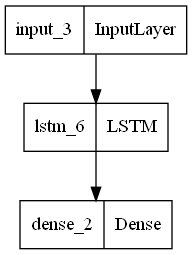

In [45]:
# keras.utils.plot_model(model, to_file='multilayer_perceptron_graph.png')
keras.utils.plot_model(model)


In [ ]:
%load_ext tensorboard

In [71]:
seq_len = days_of_history
future_predict = days_to_predict
NAME = f"{seq_len}-SEQ-{future_predict}-PRED-{int(time.time())}"#unique name for each model

# setting the optimizer parameters
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt,  loss='mae',  metrics=['mse', 'mae'])
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))

checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm.h5', save_best_only=True)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)
history = model.fit(train_ds, epochs=32, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard, checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/32
   1256/Unknown - 144s 110ms/step - loss: 1714.7162 - mse: 4667308.5000 - mae: 1714.7292WARNING:tensorflow:Can save best model only with val_loss available, skipping.
1256/1256 [==============================] - 144s 110ms/step - loss: 1714.7162 - mse: 4667308.5000 - mae: 1714.7292
Epoch 2/32
 237/1256 [====>.........................] - ETA: 1:07 - loss: 1675.7246 - mse: 4532346.5000 - mae: 1675.7258

KeyboardInterrupt: 

In [47]:
pathlib.Path.cwd()

WindowsPath('F:/projects/Drexel/DS-capstone-pt1/experiments/avk')

In [46]:
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)
history = model.fit(train_ds, epochs=32, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/32


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
# I added this to the data preprocessing, so not required

class TimeEncoding(keras.layers.Layer):
    """ Layer to encode cyclical and continuous time.  
    Input should an n x 1 array or vector of integers.  
    Integers represent number of time units (i.e., days) from the starting point"""

    def __init__(self, cyclical_interval=365, continuous_interval=3650 , **kwargs):
        self.cyclical_interval = cyclical_interval
        self.continuous_interval = continuous_interval
        super(TimeEncoding, self).__init__(**kwargs)

    def call(self, x):
        
        cyclical_sin = np.sin((x * 2 * np.pi)/self.cyclical_interval)
        cyclical_cos = np.cos((x * 2 * np.pi)/self.cyclical_interval)
        continuous_sin = np.sin((x * 2 * np.pi)/self.continuous_interval)
        continuous_cos = np.cos((x * 2 * np.pi)/self.continuous_interval)
        
        return keras.layers.concatenate([cyclical_sin, cyclical_cos, continuous_sin, continuous_cos], axis=1)
        

In [ ]:
time_encoding = TimeEncoding()
x = np.arange(30)/1.0
x = x[:, tf.newaxis]
time_encoding(x)